https://www.deeplearningbook.org/



In [3]:
from tensorflow.keras.datasets.cifar10 import load_data
from matplotlib import pyplot

import tensorflow as tf

from tensorflow.keras.layers import (
    Conv2D,
    LeakyReLU,
    Flatten,
    Conv2DTranspose,
    Dense,
    Dropout,
    Reshape,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from numpy import expand_dims, ones, zeros
from numpy.random import randn, randint

import warnings

warnings.filterwarnings("ignore")

import os

os.environ["TFCPPMINLOGLEVEL"] = "1"

In [4]:
(x_train, y_train), (x_test, y_test) = load_data()

print(
    f"Treinamento: {x_train.shape} {y_train.shape}\nTeste: {x_test.shape} {y_test.shape}"
)

Treinamento: (50000, 32, 32, 3) (50000, 1)
Teste: (10000, 32, 32, 3) (10000, 1)


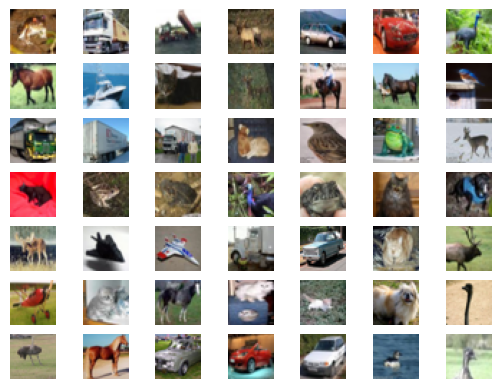

In [5]:
for i in range(49):
    pyplot.subplot(7, 7, 1 + i)
    pyplot.axis("off")
    pyplot.imshow(x_train[i])
pyplot.show()

In [6]:
def discriminator(in_shape=(32, 32, 3)):
    model = Sequential(
        [
            Conv2D(64, (3, 3), padding="same", input_shape=in_shape),
            LeakyReLU(alpha=0.2),
            Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
            LeakyReLU(alpha=0.2),
            Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
            LeakyReLU(alpha=0.2),
            Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
            LeakyReLU(alpha=0.2),
            Flatten(),
            Dropout(0.4),
            Dense(1, activation="sigmoid"),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(lr=0.002)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model

In [7]:
def load_real_samples():
    (x_train, _), (_, _) = load_data()
    x = x_train.astype("float32")
    x = (x - 127.5) / 127.5
    return x

In [8]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    x = dataset[ix]
    y = ones((n_samples))
    return (x, y)

In [9]:
def generate_fake_samples(n_samples):
    x = randn(32 * 32 * 3 * n_samples)
    x = -1 + x * 2
    x = x.reshape((n_samples, 32, 32, 3))
    y = zeros((n_samples, 1))
    return (x, y)

In [10]:
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    half_batch = int(n_batch / 2)
    for i in range(n_iter):
        x_real, y_real = generate_real_samples(dataset, half_batch)
        _, real_acc = model.train_on_batch(x_real, y_real)
        x_falso, y_falso = generate_fake_samples(half_batch)
        _, fake_acc = model.train_on_batch(x_falso, y_falso)
        print(
            ">%d real = %.0f%% fake = %.0f%%" % (i + 1, real_acc * 100, fake_acc * 100)
        )

In [11]:
model = discriminator()
dataset = load_real_samples()
train_discriminator(model, dataset)

2023-03-02 19:03:02.089651: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


>1 real = 41% fake = 0%
>2 real = 95% fake = 100%
>3 real = 53% fake = 100%
>4 real = 64% fake = 100%
>5 real = 56% fake = 100%
>6 real = 86% fake = 100%
>7 real = 81% fake = 100%
>8 real = 92% fake = 100%
>9 real = 97% fake = 100%
>10 real = 98% fake = 100%
>11 real = 98% fake = 100%
>12 real = 97% fake = 100%
>13 real = 97% fake = 100%
>14 real = 95% fake = 100%
>15 real = 98% fake = 100%
>16 real = 97% fake = 100%
>17 real = 100% fake = 100%
>18 real = 97% fake = 100%
>19 real = 100% fake = 100%
>20 real = 100% fake = 100%


In [11]:
def generator(latent_dim):
    n_nodes = 256 * 4 * 4

    model = Sequential(
        [
            Dense(n_nodes, input_dim=latent_dim),
            LeakyReLU(alpha=0.2),
            Reshape((4, 4, 256)),
            Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            LeakyReLU(alpha=0.2),
            Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            LeakyReLU(alpha=0.2),
            Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            LeakyReLU(alpha=0.2),
            Conv2D(3, (3, 3), activation="tanh", padding="same"),
        ]
    )

    return model

In [12]:
def generate_latent_points(latent_dim, n_samples):
    x_input_l = randn(latent_dim * n_samples)
    x_input_l = x_input_l.reshape(n_samples, latent_dim)
    return x_input_l

In [13]:
def fake_sampler(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    x = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return (x, y)

In [14]:
latent_dim = 100

model = generator(latent_dim)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                              

2/2 [==============================] - 0s 23ms/step


2023-03-16 19:28:20.304350: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


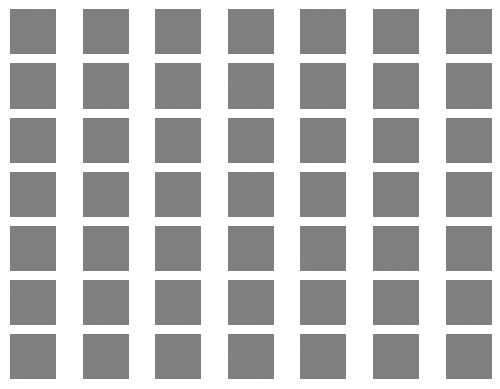

In [15]:
n_samples = 49
x, _ = fake_sampler(model, latent_dim, n_samples)
x = (x + 1) / 2.0

for i in range(n_samples):
    pyplot.subplot(7, 7, 1 + i)
    pyplot.axis("off")
    pyplot.imshow(x[i])

pyplot.show()

In [16]:
def gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential([g_model, d_model])

    opt = tf.keras.optimizers.Adam(lr=0.0002)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model

In [17]:
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = gan(g_model=g_model, d_model=d_model)
gan_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [18]:
def train_gan(gan_model, latent_dim, n_epochs=200, n_batch=128):
    for i in range(n_epochs):
        X_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        gan_model.train_on_batch(X_gan, y_gan)

In [19]:
def save_plot(examples, epoch, n=7):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis("off")
        pyplot.imshow(examples[i])
    filename = "generated_plot_e%03d.png" % (epoch + 1)
    pyplot.savefig(filename)
    pyplot.close()

In [20]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    x_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(x_real, y_real)

    x_fake, y_fake = fake_sampler(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_real, y_real)

    print(f"Acuracia REAL: {acc_real}\nAcuracia FAKE: {acc_fake}")
    save_plot(x_fake, epoch)
    g_model.save(filename)

In [21]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            x_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(x_real, y_real)

            x_fake, y_fake = fake_sampler(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(x_fake, y_fake)

            x_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))

            g_loss = gan_model.train_on_batch(x_gan, y_gan)

            print(
                ">%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f"
                % (i + 1, j + 1, batch_per_epoch, d_loss1, d_loss2, g_loss)
            )

        if (i + 1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [32]:
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

2/2 [==============================] - 0s 44ms/step
>1, 1/390, d1=0.690, d2=0.709, g=0.686
2/2 [==============================] - 0s 41ms/step
>1, 2/390, d1=0.349, d2=0.813, g=0.598
2/2 [==============================] - 0s 42ms/step
>1, 3/390, d1=0.071, d2=1.611, g=0.421
2/2 [==============================] - 0s 40ms/step
>1, 4/390, d1=0.031, d2=1.543, g=0.643
2/2 [==============================] - 0s 41ms/step
>1, 5/390, d1=0.112, d2=0.490, g=1.513
2/2 [==============================] - 0s 39ms/step
>1, 6/390, d1=0.261, d2=0.157, g=2.686
2/2 [==============================] - 0s 39ms/step
>1, 7/390, d1=0.243, d2=0.051, g=3.838
2/2 [==============================] - 0s 40ms/step
>1, 8/390, d1=0.398, d2=0.054, g=3.336
2/2 [==============================] - 0s 39ms/step
>1, 9/390, d1=0.232, d2=0.183, g=2.010
2/2 [==============================] - 0s 40ms/step
>1, 10/390, d1=0.060, d2=0.451, g=1.113
2/2 [==============================] - 0s 41ms/step
>1, 11/390, d1=0.116, d2=1.109, g=0.6

KeyboardInterrupt: 

In [33]:
gan_model.save("generator_model.h5")

In [22]:
def create_plot(examples, n):
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis("off")
        pyplot.imshow(examples[i, :, :])
    pyplot.show()

In [23]:
from tensorflow.keras.models import load_model

4/4 [==============================] - 0s 35ms/step


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

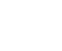

In [24]:
model = load_model("generator_model.h5")
latent_points = generate_latent_points(100, 100)
X = model.predict(latent_points)
X = (X + 1) / 2.0

create_plot(X, 10)